<center><h1>Project Shift, Don't Lift</h1></center>
<center><h5>An investigation into position prediction in Formula 1</h5></center>

---
<center><h3>Part I: Data Wrangling & EDA</h3></center>

---

## **INTRODUCTION**
This project aims to equip Formula 1 Racing Teams with an advanced data-driven driver selection solution that utilizes machine learning on driver's race results to predict finishing position. Given this objective, data must first be analyzed to gain a better understanding of what variables exist to help predict finishing position. Part I will focus on observing individual data sets found in a data collection, analyzing which features to use for a final data frame, and then conclude with EDA (exploratory data analysis) on that final data frame.

- First steps will be to import the necessary tools by using the import function.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

- The data used to tackle this problem was discovered from https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020. At this time, the entire data collection consists of individual data sets containing information on the Formula 1 races, drivers, constructors, qualifying, circuits, lap times, pit stops, and championships from 1950 till the latest 2021 season (data only for the first 9 rounds of 2021 season).
- Each individual data set will be saved to a local drive and then uploaded into JupyterLabs via pandas **pd.read_csv()** function. From here, a final dataframe will be created by joining selected features from the various individual data sets using the pandas **DataFrame.merge()** function.
- Will first start with the race results data set as seen below.

## Race Results

In [2]:
results_df = pd.read_csv('data/results.csv')
results_df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


- Looks good, will now check for null and duplicated information as seen below.

In [3]:
print(f'Shape: {results_df.shape}')
print(f"Races: {results_df['raceId'].nunique()}")
print(f"Drivers: {results_df['driverId'].nunique()}")
print(f"Constructors: {results_df['constructorId'].nunique()}")
print(f"Nulls: {results_df.isna().sum().sum()}")
print(f"Duplicates: {results_df.duplicated().sum()}")

Shape: (25140, 18)
Races: 1044
Drivers: 853
Constructors: 210
Nulls: 0
Duplicates: 0


- There are 25,140 race results from 1,044 unique races for 853 unique drivers and 210 unique constructors (teams) to work with. Next steps will be to re-name any columns for greater specificity as well as figure out which columns to drop that are considered irrelevant for predicting finishing position.

    - `resultId`: unique identifier for each race result per race/driver/constructor.
    - `raceId`: unique identifier for each race.
    - `driverId`: unique identifier for each driver.
    - `contructorId`: unique identifier for each constructor.
    - `number`: as seen before, is simply the driver's racing number and is considered irrelevant for finishing position prediction, therefore will be dropped.
    - `grid`: starting position before the race starts, essentially the results from qualifying and could help provide predictive power for finishing position.
    - `positionOrder`: is the actual finishing position result, will become **target variable** on which the model will aim to predict. `position` & `positionText` are considered irrelevant and will be dropped.
    - `points`: amount of points scored from race. The points scale has changed over the years and would be highly correlated with finishing position. Will be dropped due to these inconsistencies.
    - `laps`: number of completed laps, could help provide predictive power for finishing position.
    - `time`: total amount of time for 1st place to complete race where all remaining finishing positions only contain the additional amount of time it took to finish from 1st place's time. This will be dropped due to it's format and the inconsistencies it would bring.
    - `milliseconds`: total amount of race time in ms recorded for each driver. This could help provide predictive power for finishing position.
    - `fastestLap`: the lap number in which the driver conducted their fasted lap time in the race. This could help provide predictive power for finishing position.
    - `rank`: assumed to be the current rank in the season's championship standings, however contains 18,249 **\N** values and isn't mentioned from the data source (kaggle). Due to lack of info and ambiguity, will be dropped.
    - `fastestLapTime`: driver's fastest lap time of the race. This could help provide predictive power for finishing position.
    - `fastestLapSpeed`: driver's fastest lap speed of the race. This could help provide predictive power for finishing position, however probably has a good chance of producing large positive correlation with `fastestLapTime`.
    - `statusId`: unique status id which will be used later to join a race finish status feature.


- Additional steps are to look at the selected columns to keep and confirm there is no ambiguity. Though there is technically 0 null values, this data set contains **\N** values for what is assumed to be null or missing data points.

In [4]:
results_df['grid'].unique() # check for ambiguity or values labeled "\N"

array([ 1,  5,  7, 11,  3, 13, 17, 15,  2, 18, 19, 20,  4,  8,  6, 22, 14,
       12, 21,  9, 16, 10,  0, 23, 24, 25, 26, 27, 28, 29, 31, 30, 32, 33,
       34], dtype=int64)

In [5]:
results_df['grid'].value_counts().loc[0]

1589

In [6]:
results_df['grid'].value_counts(normalize=True).loc[0] * 100

6.3206046141607

 - `grid` looks good, except grid spot of "0". This most likely means a driver is starting at the back for a variety of reasons, but for whatever reason was encoded as '0' for these races. Will need to keep this in mind for modeling given drivers are starting here over 6% of the time, but are numerically misrepresented in order of grid position.

In [7]:
results_df['positionOrder'].unique() # check for ambiguity or values labeled "\N"

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39], dtype=int64)

- `positionOrder` looks good, will become target variable as mentioned and re-named to `finishing_position` for further clarification.

In [8]:
results_df['laps'].unique() # check for ambiguity or values labeled "\N"

array([ 58,  57,  55,  53,  47,  43,  32,  30,  29,  25,  19,   8,   0,
        56,  54,  39,   5,   1,  40,  66,  65,  41,  34,  21,   7,   6,
        24,  76,  75,  72,  67,  59,  36,  70,  69,  51,  46,  44,  13,
        16,  60,  38,  35,  10,  50,  68,  62,  22,  45,  42,  52,  11,
        61,  49,  14,   2,  71,  48,  28,  26,  64,  63,   9,  78,  77,
        17,  73,  18,   4,  33,  20,  15,  37,  23,  12,  31,   3,  27,
        74,  83,  82,  81,  80,  79,  84,  85,  96,  95,  93,  92,  90,
        94,  89,  88,  87,  86, 108, 107, 106, 105, 104, 101, 100,  98,
       103,  99,  97, 110, 109, 102,  91, 200, 196, 194, 191, 185, 152,
       134, 132, 129, 125, 182, 163, 162, 150, 147, 136, 115, 112, 189,
       151, 148, 122, 116, 199, 197, 195, 192, 170, 138, 111, 187, 175,
       173, 160, 131, 178, 168, 142, 120, 119, 193, 181, 172, 165, 130,
       190, 184, 183, 177, 176, 169, 166, 146, 180, 135, 126, 123, 137,
       133, 128, 127], dtype=int64)

 - `laps` looks good, will keep for modeling and re-name to `laps_completed` for further clarification.

In [9]:
results_df['milliseconds'].value_counts() # check for ambiguity or values labeled "\N"

\N          18460
14259460        5
10928200        3
5403200         2
4925000         2
            ...  
6164200         1
5782237         1
5445271         1
5944726         1
10377000        1
Name: milliseconds, Length: 6644, dtype: int64

In [10]:
results_df['milliseconds'].value_counts(normalize=True).loc[r'\N']*100 # prefix the '\N' string with r to produce a raw string or else it will error.

73.42879872712808

- There are 18,460 **\N** values which is assumed to represent null. This is unfortunate as `milliseconds` could have been a good feature for finishing position prediction, however will be dropped due to these values making up 73% of all milliseconds data.

In [11]:
results_df['fastestLap'].value_counts() # check for ambiguity or values labeled "\N"

\N    18416
50      241
52      231
53      225
51      211
      ...  
77       12
78        6
73        5
80        3
85        2
Name: fastestLap, Length: 80, dtype: int64

In [12]:
results_df['fastestLap'].value_counts(normalize=True).loc[r'\N']*100

73.25377883850437

- There are 18,416 **\N** values which is assumed to represent null. This is unfortunate as `fastestLap` could have been a good feature for finishing position prediction, however will be dropped due to these values making up 73% of all fastest lap data.

In [13]:
results_df['fastestLapTime'].value_counts() # check for ambiguity or values labeled "\N"

\N          18416
1:18.262        4
1:43.026        4
1:18.462        3
1:28.918        3
            ...  
1:51.594        1
1:20.790        1
1:27.294        1
1:35.991        1
1:32.148        1
Name: fastestLapTime, Length: 6223, dtype: int64

In [14]:
results_df['fastestLapTime'].value_counts(normalize=True).loc[r'\N']*100

73.25377883850437

- There are 18,416 **\N** values which is assumed to represent null. This is unfortunate as `fastestLapTime` could have been a good feature for finishing position prediction, however will be dropped due to these values making up 73% of all fastest lap time data.

In [15]:
results_df['fastestLapSpeed'].value_counts() # check for ambiguity or values labeled "\N"

\N         18416
201.330        3
196.785        3
220.611        3
213.224        3
           ...  
196.077        1
223.201        1
210.132        1
177.752        1
219.660        1
Name: fastestLapSpeed, Length: 6349, dtype: int64

In [16]:
results_df['fastestLapSpeed'].value_counts(normalize=True).loc[r'\N']*100

73.25377883850437

- There are 18,416 **\N** values which is assumed to represent null. This is unfortunate as `fastestLapSpeed` could have been a good feature for finishing position prediction, however will be dropped due to these values making up 73% of all fastest lap speed data.
- Now that the selected columns have been reviewed from results, it's time to rename & drop the appropriate columns.

In [17]:
results_df = results_df.rename(columns = {'positionOrder':'finishing_position', 'laps':'completed_laps'})
results_df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,finishing_position,points,completed_laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [18]:
results_df = results_df.drop(['resultId', 'number', 'position', 'positionText', 'points', 'time', 'milliseconds', 'rank','fastestLap','fastestLapTime', 'fastestLapSpeed'], axis=1)
results_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,statusId
0,18,1,1,1,1,58,1
1,18,2,2,5,2,58,1
2,18,3,3,7,3,58,1
3,18,4,4,11,4,58,1
4,18,5,1,3,5,58,1


## Finishing Status

In [19]:
status_df = pd.read_csv('data/status.csv')
status_df.head()

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [20]:
print(f'Shape: {status_df.shape}')
print(f"Statuses: {status_df['statusId'].nunique()}")
print(f'Nulls: {status_df.isna().sum().sum()}')
print(f'Duplicates: {status_df.duplicated().sum()}')

Shape: (137, 2)
Statuses: 137
Nulls: 0
Duplicates: 0


In [21]:
status_df['status'].sort_values().unique() # check for ambiguity or values labeled "\N"

array(['+1 Lap', '+10 Laps', '+11 Laps', '+12 Laps', '+13 Laps',
       '+14 Laps', '+15 Laps', '+16 Laps', '+17 Laps', '+18 Laps',
       '+19 Laps', '+2 Laps', '+20 Laps', '+21 Laps', '+22 Laps',
       '+23 Laps', '+24 Laps', '+25 Laps', '+26 Laps', '+29 Laps',
       '+3 Laps', '+30 Laps', '+38 Laps', '+4 Laps', '+42 Laps',
       '+44 Laps', '+46 Laps', '+49 Laps', '+5 Laps', '+6 Laps',
       '+7 Laps', '+8 Laps', '+9 Laps', '107% Rule', 'Accident',
       'Alternator', 'Axle', 'Battery', 'Brake duct', 'Brakes',
       'Broken wing', 'CV joint', 'Chassis', 'Clutch', 'Collision',
       'Collision damage', 'Crankshaft', 'Damage', 'Debris',
       'Did not prequalify', 'Did not qualify', 'Differential',
       'Disqualified', 'Distributor', 'Driver Seat', 'Driver unwell',
       'Driveshaft', 'Drivetrain', 'ERS', 'Electrical', 'Electronics',
       'Engine', 'Engine fire', 'Engine misfire', 'Excluded', 'Exhaust',
       'Eye injury', 'Fatal accident', 'Finished', 'Fire', 'Front win

There are 137 different race finishing statuses.
- `statusId`: unique identifier for status feature.
- `status`: race finishing status, this could help provide predictive power for finishing position.

Given that status is just two columns, will go ahead and merge them now to **results_df** to save time.

In [22]:
results_df = pd.merge(results_df, status_df, on = "statusId") 
results_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,statusId,status
0,18,1,1,1,1,58,1,Finished
1,18,2,2,5,2,58,1,Finished
2,18,3,3,7,3,58,1,Finished
3,18,4,4,11,4,58,1,Finished
4,18,5,1,3,5,58,1,Finished


- Looks good, now `statusId` will be dropped as this just duplicates information.

In [23]:
results_df = results_df.drop(['statusId'], axis=1)
results_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,status
0,18,1,1,1,1,58,Finished
1,18,2,2,5,2,58,Finished
2,18,3,3,7,3,58,Finished
3,18,4,4,11,4,58,Finished
4,18,5,1,3,5,58,Finished


## Races

In [24]:
races_df = pd.read_csv('data/races.csv')
races_df.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [25]:
print(f'Shape: {races_df.shape}')
print(f'Nulls: {races_df.isna().sum().sum()}')
print(f'Duplicates: {races_df.duplicated().sum()}')

Shape: (1058, 8)
Nulls: 0
Duplicates: 0


- `raceId`: unique identifier for each race
- `year`: year of race, this could help provide predictive power for finishing position.
- `round`: series's round number in the championship, this could help provide predictive power for finishing position.
- `circuitId`: unique identifier for each circuit
- `name`: name of the race, is considered irrelevant for finishing position prediction, therefore will be dropped.
- `date`: date of race, this could help provide predictive power for finishing position.
- `time`: start time of race, this could help provide predictive power for finishing position.
- `url`: wiki link of race, is considered irrelevant for finishing position prediction, therefore will be dropped.

Next steps are to look at the selected columns to keep and confirm there is no ambiguity.

In [26]:
races_df['raceId'].nunique()

1058

- There is 1,058 unique races in the **races_df**, however only 1,044 unique races in the **results_df**. These 14 races with no results won't appear in the final data set, however it would be nice to know why these races did not have finishing results. A few assumptions could be that these are older races and the results for whatever reason are not available, or could be canceled races due to weather or disasters. 

In [27]:
races_df['year'].sort_values().unique() # check for ambiguity or values labeled "\N"

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [28]:
races_df['round'].unique() # check for ambiguity or values labeled "\N"

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23], dtype=int64)

In [29]:
races_df['circuitId'].sort_values().unique() # check for ambiguity or values labeled "\N"

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 73, 75, 76, 77], dtype=int64)

In [30]:
races_df['date'].nunique()

1058

In [31]:
races_df['time'].value_counts() # check for ambiguity or values labeled "\N"

\N          731
12:00:00    109
13:10:00     30
14:00:00     30
13:00:00     23
06:00:00     20
16:00:00     12
07:00:00     11
19:00:00     10
15:00:00      9
05:00:00      9
12:10:00      6
17:00:00      6
18:00:00      6
08:00:00      5
11:00:00      4
05:10:00      4
04:30:00      3
09:30:00      3
19:10:00      3
18:10:00      3
17:10:00      3
11:10:00      3
15:10:00      2
06:10:00      2
10:10:00      2
14:10:00      2
11:30:00      2
14:30:00      2
09:00:00      1
20:00:00      1
03:00:00      1
Name: time, dtype: int64

- There are 731 **\N** values which is assumed to represent null. This is unfortunate as `time` of the race could have been a feature for finishing position prediction, however will be dropped due to the majority of missing data it contains. Now that the selected columns have been reviewed and there is no ambiguous data found, it's time to rename any columns for greater specificity as well as drop the appropriate columns.

In [32]:
races_df = races_df.rename(columns = {'name':'race_name'})
races_df.head()

,raceId,year,round,circuitId,race_name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [33]:
races_df = races_df.drop(['year', 'race_name', 'time', 'url'], axis=1)
races_df.head()

,raceId,round,circuitId,date
0,1,1,1,2009-03-29
1,2,2,2,2009-04-05
2,3,3,17,2009-04-19
3,4,4,3,2009-04-26
4,5,5,4,2009-05-10


## Drivers

In [34]:
drivers_df = pd.read_csv('data/drivers.csv')
drivers_df.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [35]:
print(f'Shape: {drivers_df.shape}')
print(f'Nulls: {drivers_df.isna().sum().sum()}')
print(f'Duplicates: {drivers_df.duplicated().sum()}')

Shape: (853, 9)
Nulls: 0
Duplicates: 0


Columns containing duplicate info or considered irrelevant for predicting finishing position will be dropped as seen below.

- `driverId`: unique identifier for each driver.
- `driverRef`: single reference for each unique driver, will use as driver identifier feature as this combines features of a driver's first and last name for unique identification.
- `number`:driver's racing number and is considered irrelevant for finishing position prediction, therefore will be dropped.
- `code`: 3 letter representation of drivers last name, is a bit ambiguous, considered duplicate info, and will be dropped.
- `forename`: driver's first name, considered duplicate info and will be dropped.
- `surname`: driver's last name, considered duplicate info and will be dropped.
- `dob`: driver's date of birth, could help provide predictive power for finishing position.
- `nationality`: driver's nationality, could help provide predictive power for finishing position.
- `url`: wikie link on driver, considered irrelevant for finishing position prediction, therefore will be dropped.

Next steps are to look at the selected columns to keep and confirm there is no ambiguity.

In [36]:
drivers_df['driverRef'].nunique()

853

- There are 853 unique drivers to work with which also matches the amount of unique drivers found from the results data.

In [37]:
drivers_df['dob'].unique() # check for ambiguity or values labeled "\N"

array(['1985-01-07', '1977-05-10', '1985-06-27', '1981-07-29',
       '1981-10-19', '1985-01-11', '1979-02-28', '1979-10-17',
       '1984-12-07', '1982-03-18', '1977-01-28', '1985-07-25',
       '1981-04-25', '1971-03-27', '1974-07-13', '1983-01-11',
       '1976-08-27', '1980-01-19', '1979-04-18', '1987-07-03',
       '1973-01-14', '1972-05-23', '1975-06-30', '1980-08-06',
       '1974-02-15', '1983-01-24', '1979-04-16', '1980-06-13',
       '1982-07-09', '1969-01-03', '1975-09-20', '1983-02-07',
       '1976-07-24', '1975-01-21', '1971-04-09', '1978-01-05',
       '1971-02-24', '1981-09-23', '1977-01-14', '1980-09-26',
       '1976-03-23', '1980-09-11', '1973-09-19', '1966-09-02',
       '1979-02-04', '1981-05-30', '1981-01-01', '1974-03-29',
       '1967-05-18', '1972-03-04', '1978-07-31', '1975-05-20',
       '1978-03-03', '1975-03-05', '1964-06-11', '1965-11-10',
       '1968-09-28', '1976-01-19', '1978-10-19', '1975-05-08',
       '1976-09-11', '1976-07-20', '1966-11-30', '1970-

In [38]:
drivers_df['nationality'].unique() # check for ambiguity or values labeled "\N"

array(['British', 'German', 'Spanish', 'Finnish', 'Japanese', 'French',
       'Polish', 'Brazilian', 'Italian', 'Australian', 'Austrian',
       'American', 'Dutch', 'Colombian', 'Portuguese', 'Canadian',
       'Indian', 'Hungarian', 'Irish', 'Danish', 'Argentine', 'Czech',
       'Malaysian', 'Swiss', 'Belgian', 'Monegasque', 'Swedish',
       'Venezuelan', 'New Zealander', 'Chilean', 'Mexican',
       'South African', 'Liechtensteiner', 'Rhodesian',
       'American-Italian', 'Uruguayan', 'Argentine-Italian', 'Thai',
       'East German', 'Russian', 'Indonesian'], dtype=object)

- Now that the selected columns have been reviewed and there is no ambiguous data found, it's time to drop the appropriate columns.

In [39]:
drivers_df = drivers_df.drop(['forename', 'surname', 'number', 'code', 'url'], axis=1)
drivers_df.head()

,driverId,driverRef,dob,nationality
0,1,hamilton,1985-01-07,British
1,2,heidfeld,1977-05-10,German
2,3,rosberg,1985-06-27,German
3,4,alonso,1981-07-29,Spanish
4,5,kovalainen,1981-10-19,Finnish


## Driver Standings

In [40]:
ds = pd.read_csv('data/driver_standings.csv')
ds.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [41]:
ds['driverId'].nunique()

846

In [42]:
ds['raceId'].nunique()

1045

In [43]:
ds['points'].unique() # check for ambiguity or values labeled "\N"

array([ 10.  ,   8.  ,   6.  ,   5.  ,   4.  ,   3.  ,   2.  ,   1.  ,
        14.  ,  11.  ,   0.  ,  16.  ,   7.  ,  19.  ,  20.  ,  29.  ,
         9.  ,  18.  ,  28.  ,  35.  ,  24.  ,  38.  ,  15.  ,  32.  ,
        34.  ,  42.  ,  12.  ,  43.  ,  46.  ,  48.  ,  36.  ,  13.  ,
        58.  ,  41.  ,  51.  ,  54.  ,  62.  ,  57.  ,  49.  ,  22.  ,
        70.  ,  55.  ,  26.  ,  64.  ,  76.  ,  23.  ,  74.  ,  78.  ,
        53.  ,  77.  ,  84.  ,  56.  ,  17.  ,  27.  ,  63.  ,  72.  ,
        30.  ,  21.  ,  79.  ,  87.  ,  75.  ,  69.  ,  60.  ,  94.  ,
        98.  ,  61.  ,  31.  ,  97.  ,  25.  ,  33.  ,  40.  ,  39.  ,
        47.  ,  50.  ,  59.  ,  73.  ,  52.  ,  89.  ,  95.  ,  80.  ,
        86.  , 103.  , 110.  , 109.  ,  44.  ,  37.  ,  88.  ,  96.  ,
       100.  ,  90.  , 108.  , 106.  ,  45.  , 116.  , 126.  ,  65.  ,
       121.  , 134.  ,  71.  , 111.  , 117.  , 123.  , 104.  , 133.  ,
       112.  ,  68.  ,  82.  , 120.  , 128.  , 136.  ,  85.  , 146.  ,
      

- Driver Standings only provides results for 1045/1058 unique races, 846/853 drivers, and contains inconsistent points due to changes in the point structure over time.
- Due to these inconsistencies, no features from this data set will be used.

## Circuits

In [44]:
circuits_df = pd.read_csv('data/circuits.csv')
circuits_df.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [45]:
print(f'Shape: {circuits_df.shape}')
print(f'Nulls: {circuits_df.isna().sum().sum()}')
print(f'Duplicates: {circuits_df.duplicated().sum()}')

Shape: (77, 9)
Nulls: 0
Duplicates: 0


- `circuitId`: unique identifier for each circuit.
- `circuitRef`: unique reference for each circuit, is considered irrelevant for finishing position prediction, therefore will be dropped.
- `name`: name of circuit, is considered irrelevant for finishing position prediction, therefore will be dropped.
- `location`: city of circuit, this could help provide predictive power for finishing position however `lat` & `lng` are already encoded features for modeling and therefore will be dropped.
- `country`: country of circuit, this could help provide predictive power for finishing position however `lat` & `lng` are already encoded features for modeling and therefore will be dropped.
- `lat`: latitude of circuit, this could help provide predictive power for finishing position and will be utilized for circuit location.
- `lng`: longitude of circuit, this could help provide predictive power for finishing position and will be utilized for circuit location.
- `url`: wiki link of each circuit, is considered irrelevant for finishing position prediction, therefore will be dropped.

Next steps are to look at the selected columns to keep and confirm there is no ambiguity.

In [46]:
circuits_df['circuitId'].nunique()

77

In [47]:
circuits_df['lat'].nunique()

76

In [48]:
circuits_df['lng'].nunique()

76

In [49]:
group = circuits_df.groupby('lat')['name'].unique() # group by circuit `lat` & 'name'
duplicate = group[group.apply(lambda x: len(x)>1)] # filter out unique `lat` with more than 1 `name`
duplicate

lat
47.2197    [A1-Ring, Red Bull Ring]
Name: name, dtype: object

- There are 77 unique circuits, however only 76 unique locations. This could be a result of a previous tracks changing names and/or ownership, but still remaining in the same location. As seen below, it appears this is the case where the A1-Ring changed ownership and renamed to Red Bull Ring. For the sake of modeling, will still only use `lat` and `lng` for circuit information to avoid any duplicate information.
- Now that the selected columns have been reviewed, it's time to rename & drop the appropriate columns.

In [50]:
circuits_df = circuits_df.rename(columns = {'lat':'circuit_lat', 'lng':'circuit_lng'})
circuits_df.head()

,circuitId,circuitRef,name,location,country,circuit_lat,circuit_lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [51]:
circuits_df = circuits_df.drop(['circuitRef', 'name', 'location', 'country', 'alt', 'url'], axis=1)
circuits_df.head()

,circuitId,circuit_lat,circuit_lng
0,1,-37.84970,144.96800
1,2,2.76083,101.73800
2,3,26.03250,50.51060
3,4,41.57000,2.26111
4,5,40.95170,29.40500


## Lap_Times

In [52]:
laps_df = pd.read_csv('data/lap_times.csv')
laps_df.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [53]:
print(f'Shape: {laps_df.shape}')
print(f'Nulls: {laps_df.isna().sum().sum()}')
print(f'Duplicates: {laps_df.duplicated().sum()}')

Shape: (501586, 6)
Nulls: 0
Duplicates: 0


- `raceId`: unique identifier for each race.
- `driverId`: unique identifier for each driver.
- `lap`: lap number, this could help provide predictive power for finishing position by engineering a feature to show change in position per lap.
- `position`: race position by the end of the lap, this could help provide predictive power for finishing position by engineering a feature to show change in position per lap.
- `time`: lap time, this could help provide predictive power for finishing position as well as opportunity for engineered features such as `lap_difference`.
- `milliseconds`: lap time in milliseconds, is considered duplicate information and would be dropped.

Next steps are to look at the selected columns to keep and confirm there is no ambiguity.

In [54]:
laps_df['raceId'].nunique()

463

In [55]:
results_df['raceId'].nunique()

1044

In [56]:
laps_df['raceId'].nunique() / results_df['raceId'].nunique() *100

44.34865900383142

- There are only 463 unique races observed in the lap time data set, however there is a total of 1,044 unique races out of the entire results data set that contains the target variable, finishing position. 

In [57]:
laps_df['driverId'].nunique()

135

In [58]:
drivers_df['driverId'].nunique()

853

In [59]:
laps_df['driverId'].nunique() / drivers_df['driverId'].nunique() *100

15.826494724501758

- There is lap time data for only ~44% of all races as well as for only ~16% of all divers in the entire data set. 
- In effort to avoid any null values, will not include individual lap times. This is really unfortunate as individual lap time data could help provide predictive power for finishing position, however will keep in mind for future modeling.

## Constructors

In [60]:
constructors_df = pd.read_csv('data/constructors.csv')
constructors_df.head()

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [61]:
print(f'Shape: {constructors_df.shape}')
print(f'# of Nulls: {constructors_df.isna().sum().sum()}')
print(f'# of Duplicates: {constructors_df.duplicated().sum()}')

Shape: (211, 5)
# of Nulls: 0
# of Duplicates: 0


- `constructorId`: unique identifier for each constructor.
- `constructorRef`: unique reference for each constructor, is considered irrelevant for finishing position prediction, therefore will be dropped.
- `name`: constructor name, this could help provide predictive power for finishing position.
- `nationality`: constructor nationality, this could help provide predictive power for finishing position.
- `url`: wiki link for each constructor, is considered irrelevant for finishing position prediction, therefore will be dropped.

Next steps are to look at the selected columns to keep and confirm there is no ambiguity.

In [62]:
constructors_df['constructorId'].nunique()

211

- There is a total of 211 unique constructors however only 210 unique constructors found in the results data.

In [63]:
ucon_df = pd.merge(constructors_df, results_df, how='left', on = "constructorId") # left join between the constructors_df & results_df
bool_series = pd.isnull(ucon_df['raceId']) # creating bool series True for NaN values
ucon_df[bool_series] # displayind data only with raceId = NaN

,constructorId,constructorRef,name,nationality,url,raceId,driverId,grid,finishing_position,completed_laps,status
20521,88,eagle,Eagle,American,http://en.wikipedia.org/wiki/Anglo_American_Ra...,NaN,NaN,NaN,NaN,NaN,NaN


- After conducting a left join between the **constructors_df** & **results_df**, it appears there are no results for the constructor **Eagle**. 
- It also appears there are different variations of the constructor Eagle (Eagle-Climax & Eagle-Weslake) as seen below and therefore could simply be a data entry error.

In [64]:
constructors_df['name'].sort_values(ascending=True).unique() # check for ambiguity or values labeled "\N"

array(['AFM', 'AGS', 'ATS', 'Adams', 'Alfa Romeo', 'AlphaTauri',
       'Alpine F1 Team', 'Alta', 'Amon', 'Andrea Moda', 'Apollon',
       'Arrows', 'Arzani-Volpini', 'Aston Butterworth', 'Aston Martin',
       'BAR', 'BMW', 'BMW Sauber', 'BRM', 'BRM-Ford', 'BRP',
       'Behra-Porsche', 'Bellasi', 'Benetton', 'Boro', 'Brabham',
       'Brabham-Alfa Romeo', 'Brabham-BRM', 'Brabham-Climax',
       'Brabham-Ford', 'Brabham-Repco', 'Brawn', 'Bromme', 'Bugatti',
       'Caterham', 'Christensen', 'Cisitalia', 'Coloni', 'Connaught',
       'Connew', 'Cooper', 'Cooper-ATS', 'Cooper-Alfa Romeo',
       'Cooper-BRM', 'Cooper-Borgward', 'Cooper-Castellotti',
       'Cooper-Climax', 'Cooper-Ferrari', 'Cooper-Ford',
       'Cooper-Maserati', 'Cooper-OSCA', 'Dallara', 'De Tomaso',
       'De Tomaso-Alfa Romeo', 'De Tomaso-Ferrari', 'De Tomaso-Osca',
       'Deidt', 'Del Roy', 'Derrington', 'Dunn', 'EMW', 'ENB', 'ERA',
       'Eagle', 'Eagle-Climax', 'Eagle-Weslake', 'Elder', 'Embassy Hill',
       

In [65]:
constructors_df['nationality'].unique() # check for ambiguity or values labeled "\N"

array(['British', 'German', 'French', 'Italian', 'Japanese', 'Austrian',
       'Indian', 'Dutch', 'Russian', 'Swiss', 'Irish', 'Hong Kong',
       'Brazilian', 'Canadian', 'Mexican', 'American', 'Australian',
       'New Zealand', 'South African', 'Rhodesian', 'Belgium',
       'East German', 'Spanish', 'Malaysian'], dtype=object)

- Now that the selected columns have been reviewed and there is no ambiguous data found, it's time to rename any columns for greater specificity as well as drop the appropriate columns.

In [66]:
constructors_df = constructors_df.rename(columns = {'name':'constructor', 'nationality':'constructor_nationality'})
constructors_df.head()

,constructorId,constructorRef,constructor,constructor_nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [67]:
constructors_df = constructors_df.drop(['constructorRef', 'url'], axis=1)
constructors_df.head()

,constructorId,constructor,constructor_nationality
0,1,McLaren,British
1,2,BMW Sauber,German
2,3,Williams,British
3,4,Renault,French
4,5,Toro Rosso,Italian


## Constructor Results

In [68]:
cr = pd.read_csv('data/constructor_results.csv')
cr.head()

,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N


In [69]:
cr['raceId'].nunique()

981

In [70]:
cr['constructorId'].nunique()

175

In [71]:
cr['points'].unique()

array([14. ,  8. ,  9. ,  5. ,  2. ,  1. ,  0. , 10. , 11. , 18. ,  4. ,
        3. ,  6. , 16. ,  7. , 13. , 15. , 12. ,  1.5,  0.5,  5.5,  4.5,
        2.5, 19. , 43. , 21. , 33. , 27. , 40. , 26. , 20. , 22. , 25. ,
       31. , 30. , 17. , 23. , 29. , 35. , 37. , 28. , 24. , 50. , 66. ,
       32. , 44. , 38. , 34. , 41. ])

- Constructor results only provides results for 981/1058 unique races, 175/211 constructors, and contains inconsistent points due to changes in the point structure over time.
- Due to these inconsistencies, no features from this data set will be used.

## Constructor Standings

In [72]:
cs = pd.read_csv('data/constructor_standings.csv')
cs.head()

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


In [73]:
cs['raceId'].nunique()

981

In [74]:
cs['constructorId'].nunique()

159

In [75]:
cs['points'].unique() # check for ambiguity or values labeled "\N"

array([ 14. ,   8. ,   9. ,   5. ,   2. ,   1. ,  24. ,  19. ,   6. ,
        11. ,   0. ,  28. ,  30. ,  10. ,  29. ,   4. ,  34. ,  35. ,
        12. ,  47. ,   3. ,  42. ,  44. ,  13. ,  63. ,  53. ,  52. ,
        15. ,  69. ,  70. ,   7. ,  73. ,  17. ,  21. ,  58. ,  74. ,
        91. ,  23. ,  72. ,  82. ,  16. ,  96. ,  25. ,  86. ,  89. ,
       105. , 100. ,  90. ,  31. , 111. , 113. , 121. ,  41. , 119. ,
       107. ,  36. , 131. , 129. , 117. ,  27. , 134. ,  26. , 135. ,
       120. ,  51. ,  46. , 128. ,  66. , 142. ,  50. , 156. , 145. ,
       151. ,  80. ,  39. , 172. ,  56. ,  18. ,  76. ,  38. ,  88. ,
       106. ,  48. , 114. ,  32. ,  61. , 138. ,  20. ,  33. ,  71. ,
        22. ,  77. , 148. , 166. , 192. ,  92. , 202. ,  94. , 210. ,
       101. , 118. ,  62. ,  59. ,  78. ,  75. ,  65. ,  87. ,  37. ,
       139. , 149. ,  85. , 158. , 160. ,  97. , 168. , 165. , 178. ,
       179. , 186. , 195. , 110. , 201. , 206. ,  40. ,  43. ,  45. ,
       102. ,  54. ,

- Only provides results for 981/1058 unique races, 159/211 constructors, and contains inconsistent points due to changes in the point structure over time.
- Due to these inconsistencies, no features from this data set will be used.

## Pit Stops

In [76]:
ps = pd.read_csv('data/pit_stops.csv')
ps.head()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [77]:
ps['driverId'].nunique()

68

In [78]:
ps['raceId'].nunique()

205

- Only provides results for 19% of all unique races (205/1058) and for 24% of all unique drivers (205/853).
- Due to these inconsistencies and the goal of avoiding null values for modeling, no features from this data set will be used.

## Seasons

In [79]:
seasons = pd.read_csv('data/seasons.csv')
seasons.head()

,year,url
0,2009,https://en.wikipedia.org/wiki/2009_Formula_One...
1,2008,https://en.wikipedia.org/wiki/2008_Formula_One...
2,2007,https://en.wikipedia.org/wiki/2007_Formula_One...
3,2006,https://en.wikipedia.org/wiki/2006_Formula_One...
4,2005,https://en.wikipedia.org/wiki/2005_Formula_One...


- Only provides year, considered duplicate information and therefore no features from this data set will be used.

## Final DataFrame
Now that all individual data sets have been reviewed, a final dataframe can be created by joining the selected data sets per their unique identifier as seen below.

In [80]:
#join results with drivers by column driverID, using inner join
driver_results = pd.merge(results_df, drivers_df, on='driverId')
#join races with driver_results by column raceID, using inner join
race_results = pd.merge(driver_results, races_df, on='raceId')
#join circuits with race_results by column circuitID, using inner join
circuit_results = pd.merge(race_results, circuits_df, on='circuitId')
#join constructorDF with dfresulcons by column constructorID, using inner join
f1_df = pd.merge(circuit_results, constructors_df, on='constructorId')

f1_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,status,driverRef,dob,nationality,round,circuitId,date,circuit_lat,circuit_lng,constructor,constructor_nationality
0,18,1,1,1,1,58,Finished,hamilton,1985-01-07,British,1,1,2008-03-16,-37.8497,144.968,McLaren,British
1,18,5,1,3,5,58,Finished,kovalainen,1981-10-19,Finnish,1,1,2008-03-16,-37.8497,144.968,McLaren,British
2,36,1,1,4,3,58,Finished,hamilton,1985-01-07,British,1,1,2007-03-18,-37.8497,144.968,McLaren,British
3,36,4,1,2,2,58,Finished,alonso,1981-07-29,Spanish,1,1,2007-03-18,-37.8497,144.968,McLaren,British
4,338,1,1,11,6,58,Finished,hamilton,1985-01-07,British,2,1,2010-03-28,-37.8497,144.968,McLaren,British


In [81]:
print(f'Shape: {f1_df.shape}')
print(f'Nulls: {f1_df.isna().sum().sum()}')
print(f'Duplicates: {f1_df.duplicated().sum()}')

Shape: (25140, 17)
Nulls: 0
Duplicates: 0


- Now that a final data frame is created, time to remove duplicate information within the features.

In [82]:
f1_df = f1_df.drop(['raceId', 'driverId', 'constructorId', 'circuitId'], axis=1)
f1_df.head()

,grid,finishing_position,completed_laps,status,driverRef,dob,nationality,round,date,circuit_lat,circuit_lng,constructor,constructor_nationality
0,1,1,58,Finished,hamilton,1985-01-07,British,1,2008-03-16,-37.8497,144.968,McLaren,British
1,3,5,58,Finished,kovalainen,1981-10-19,Finnish,1,2008-03-16,-37.8497,144.968,McLaren,British
2,4,3,58,Finished,hamilton,1985-01-07,British,1,2007-03-18,-37.8497,144.968,McLaren,British
3,2,2,58,Finished,alonso,1981-07-29,Spanish,1,2007-03-18,-37.8497,144.968,McLaren,British
4,11,6,58,Finished,hamilton,1985-01-07,British,2,2010-03-28,-37.8497,144.968,McLaren,British


In [83]:
print(f'Shape: {f1_df.shape}')
print(f'Duplication: {f1_df.duplicated().sum()}')
print(f'Null Values: {f1_df.isna().sum().sum()}')

Shape: (25140, 13)
Duplication: 0
Null Values: 0


- This looks good, will save this final data frame to a csv for modeling.

In [84]:
f1_df.to_csv("data/f1_df.csv", index=False)

## Data Distribution
- This section will explore the data distribution for all numeric & categorical columns.

### Numeric Columns

In [85]:
nf1_df = f1_df.select_dtypes(["int64", "float64"])
nf1_df.head()

,grid,finishing_position,completed_laps,round,circuit_lat,circuit_lng
0,1,1,58,1,-37.8497,144.968
1,3,5,58,1,-37.8497,144.968
2,4,3,58,1,-37.8497,144.968
3,2,2,58,1,-37.8497,144.968
4,11,6,58,2,-37.8497,144.968


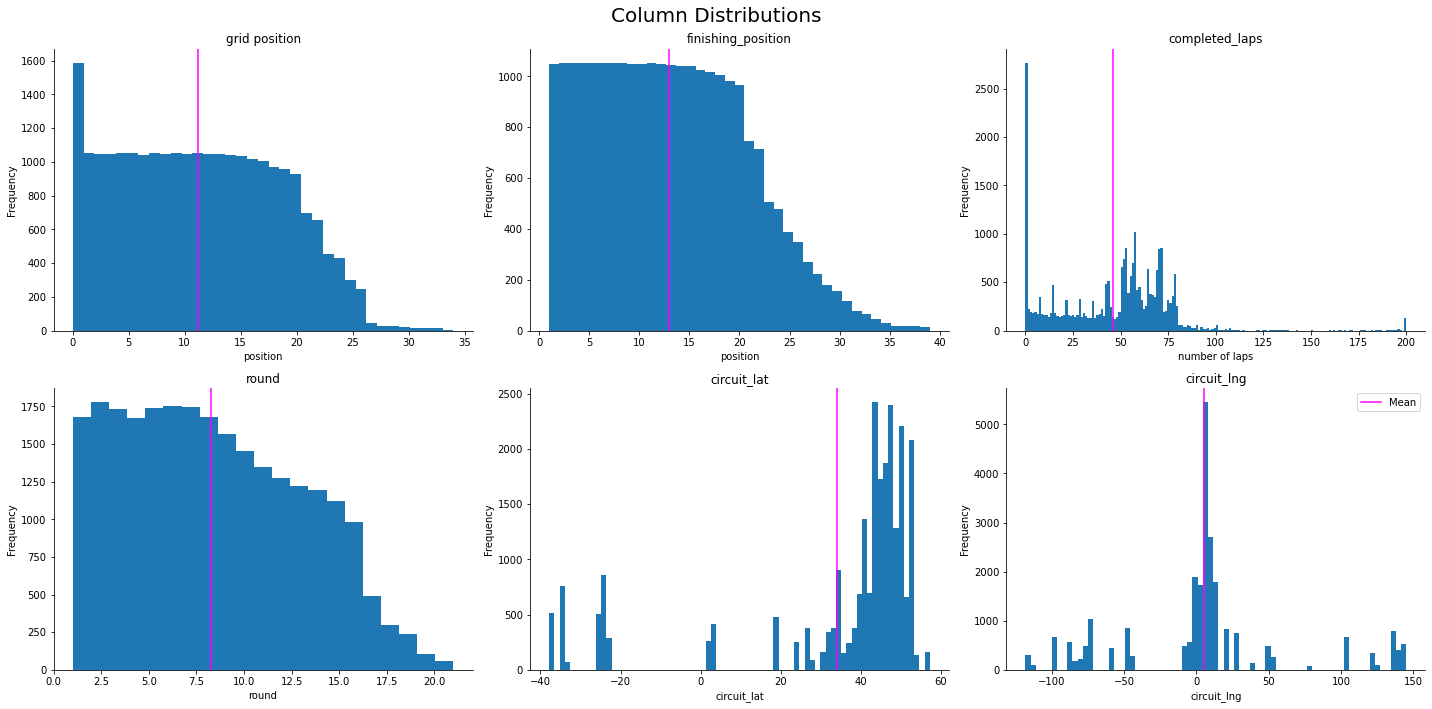

In [86]:
plt.subplots(2, 3, figsize=(20,10))  # create a 2x2 grid of subplots
plt.suptitle('Column Distributions', size=20)

# Historgram of grid
plt.subplot(2, 3, 1)
plt.hist(f1_df['grid'], bins=f1_df['grid'].nunique())
plt.title('grid position')
plt.xlabel('position')
plt.ylabel('Frequency')
plt.axvline(f1_df['grid'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of finishing_position
plt.subplot(2,3,2)
plt.hist(f1_df['finishing_position'], bins=f1_df['finishing_position'].nunique())
plt.title('finishing_position')
plt.xlabel('position')
plt.ylabel('Frequency')
plt.axvline(f1_df['finishing_position'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of completed_laps
plt.subplot(2,3,3)
plt.hist(f1_df['completed_laps'], bins=f1_df['completed_laps'].nunique())
plt.title('completed_laps')
plt.xlabel('number of laps')
plt.ylabel('Frequency')
plt.axvline(f1_df['completed_laps'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of race round
plt.subplot(2,3,4)
plt.hist(f1_df['round'], bins=f1_df['round'].nunique())
plt.title('round')
plt.xlabel('round')
plt.ylabel('Frequency')
plt.axvline(f1_df['round'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of circuit_lat
plt.subplot(2,3,5)
plt.hist(f1_df['circuit_lat'], bins=f1_df['circuit_lat'].nunique())
plt.title('circuit_lat')
plt.xlabel('circuit_lat')
plt.ylabel('Frequency')
plt.axvline(f1_df['circuit_lat'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of circuit_lng
plt.subplot(2,3,6)
plt.hist(f1_df['circuit_lng'], bins=f1_df['circuit_lng'].nunique())
plt.title('circuit_lng')
plt.xlabel('circuit_lng')
plt.ylabel('Frequency')
plt.axvline(f1_df['circuit_lng'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

plt.legend()
plt.tight_layout()
plt.show()

**Observations:**
- `grid`: skewed to the right with roughly 20-25 drivers typically qualifying for a race grid position, with an interesting amount in the 0 bin. Having a grid position of 0 could be from penalties added after qualification in which the driver simply starts at the back of the grid.
- `finishing_position`: skewed to the right, with most drivers finishing in positions 1st through ~23rd.
- `completed_laps`: somewhat normally distributed, skewed to the left, and has an interesting amount of distribution in first few laps. This makes sense as the probability of crashing within the first corner or withing the first few laps is high due to the close proximity of other cars at the beginning.
- `round`: skewed to the right with mostly about 16 races in a championship, however now days there is typically 20+ races given the advancements in travel since 1950.
- `circuit_lat`: skewed to the left with the majority of races located in Europe. This make sense given the roots of F1 started in Europe and has grown from this continent.
- `circuit_lng`: appears to be normally distributed with the majority of races located just north of the equator. This makes sense for obtaining ideal weather given these circuits are outdoors.

### Categorical Columns
- Given there are a lot categorical values, will simply look at the top 10 values for each categorical column. These values are calculated in percent of totals, sorted greatest to least. 

In [87]:
categorical_columns = f1_df.select_dtypes("object").columns # get all columns with this specific data type
categorical_columns

Index(['status', 'driverRef', 'dob', 'nationality', 'date', 'constructor',
       'constructor_nationality'],
      dtype='object')

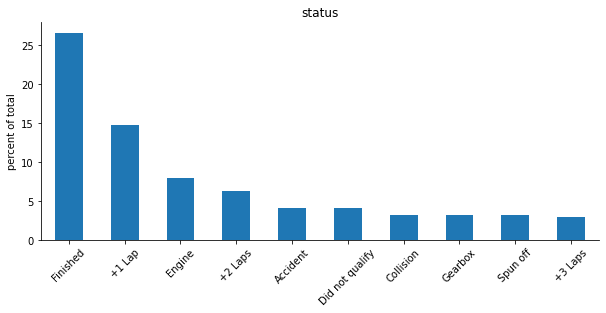

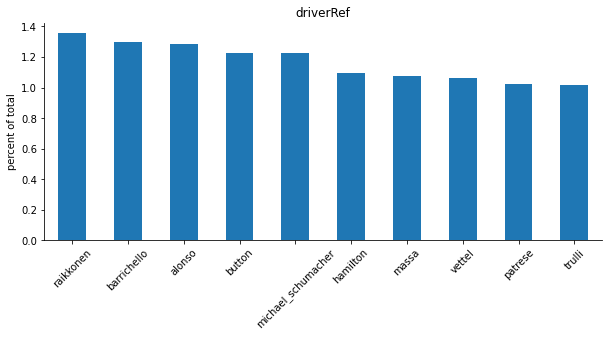

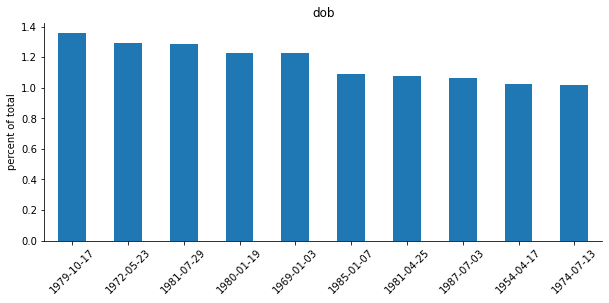

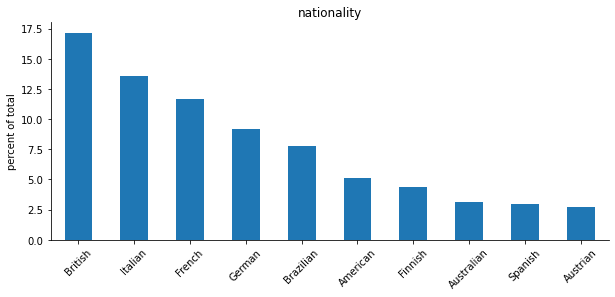

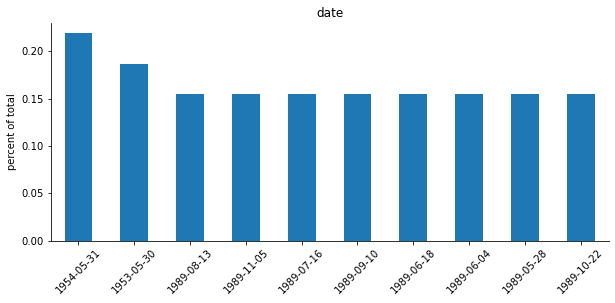

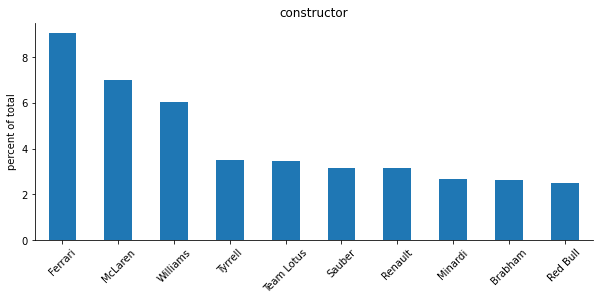

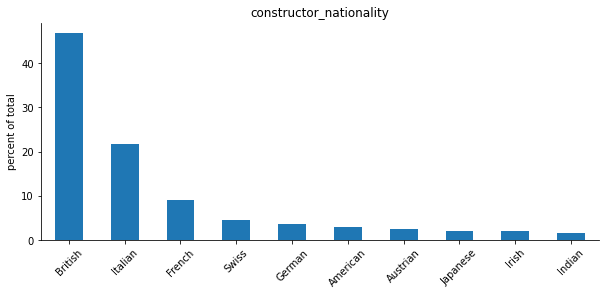

In [88]:
for col_name in categorical_columns:
    (f1_df[col_name].value_counts()/f1_df.shape[0]*100).nlargest(10).plot(kind="bar", figsize=(10, 4))
    plt.title(f"{col_name}")
    plt.ylabel("percent of total")
    plt.xticks(rotation=45) 
    sns.despine()
    plt.show()

**Key Observations**
- `Status`: Majority of drivers are finishing races, and there appears to be a lot of extra noise on if they didn't or by how many laps down they were if they did. Will binarize to finish or did not finish for modeling.
- `driverRef`: Top 10 most experienced drivers in F1, legends of the sport. Will onehotencode this feature for modeling.
- `dob`: Additional insight from dob could be in the form of age at race, will analyze further in EDA.
- `nationality`: given the sports' European roots, no surprise majority of drivers are of European nationality. The British appear to be producing the most F1 drivers. Will onehotencode for modeling.
- `constructor`: Ferrari has been a constructor in F1 from day 1 and has most races under their belt. Will onehotencode as well.
- `constructor_nationality`: The British are not only producing the most drivers, they are also producing the most teams. Will OHE this feature like the rest.

## Tableau EDA
This section focuses on the Final DataFrame's EDA utilizing imported data visuals from Tableau. Many of these visuals were created to gain a better understanding of progression in F1 as well as identify potential insights between the different variables that might help predict finishing position.

### `age_at_race`
- By subtracting race date year from driver dob year, an `age_at_race` feature can be established. The line graph below takes the average `age_at_race` and plots it over race years.

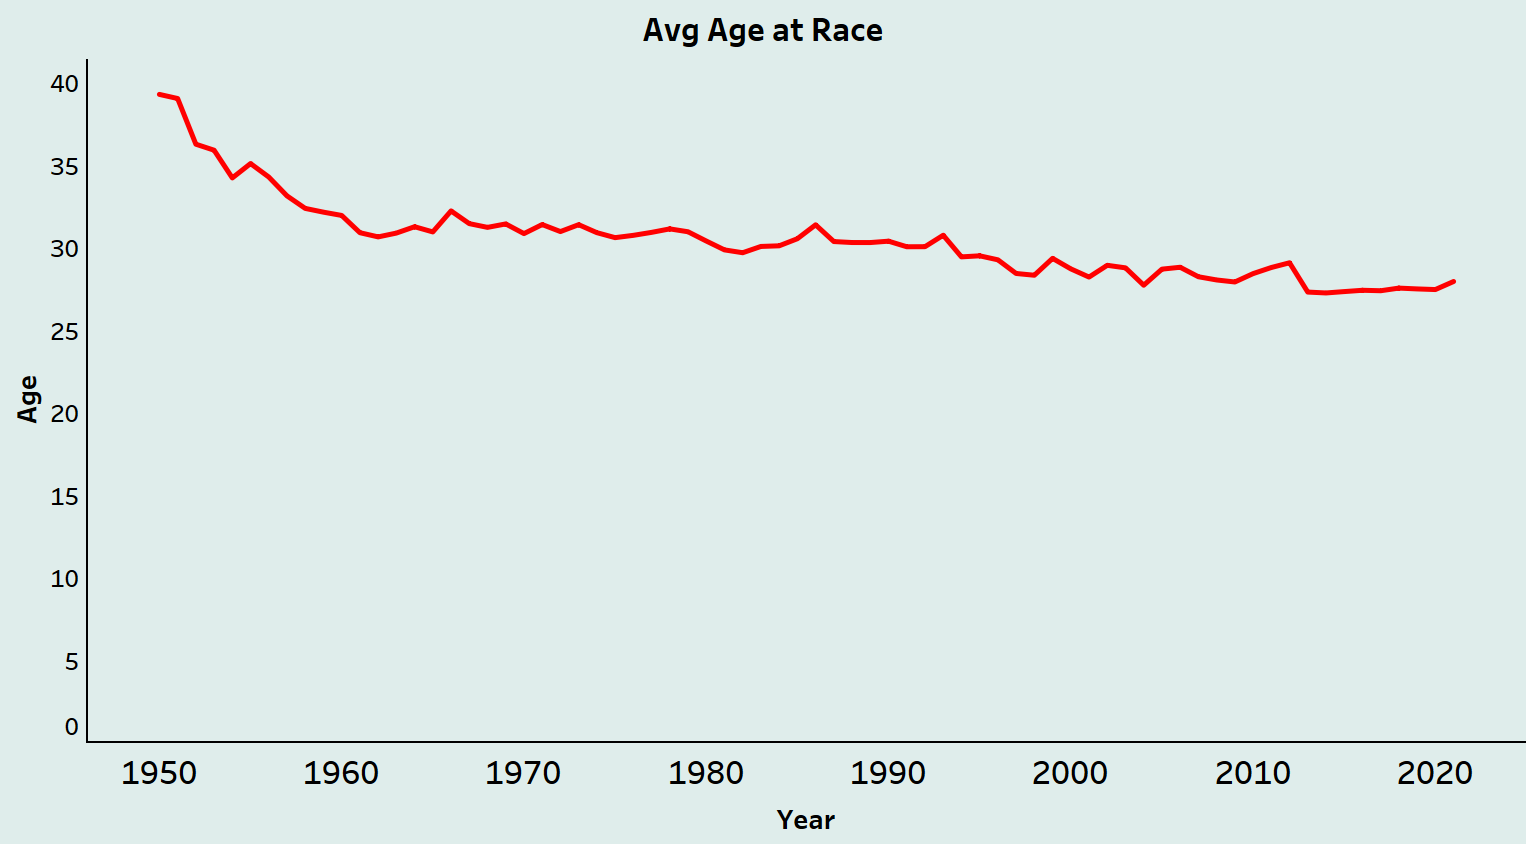

In [89]:
from IPython.display import Image #imports images
Image(filename='Images/avg_age.png', width=750) 

**Observations**
- The average age at each race has slowly decreased from ~39 years of age in 1950 to ~28 in 2021. That's more than a 10 year difference!
- A possible reason could be the increase in the amount of feeder racing series that prepare younger drivers earlier for the pressures of F1, ultimately paying off in better finishing position and increasing their demand.
- This new feature will be added to the final data frame in part II and may provider greater predictive power for finishing position.

### Circuit Map
- The below map contains red circles representing the location of each circuit, with the size of the circle representing the number of races that circuit has held over time.

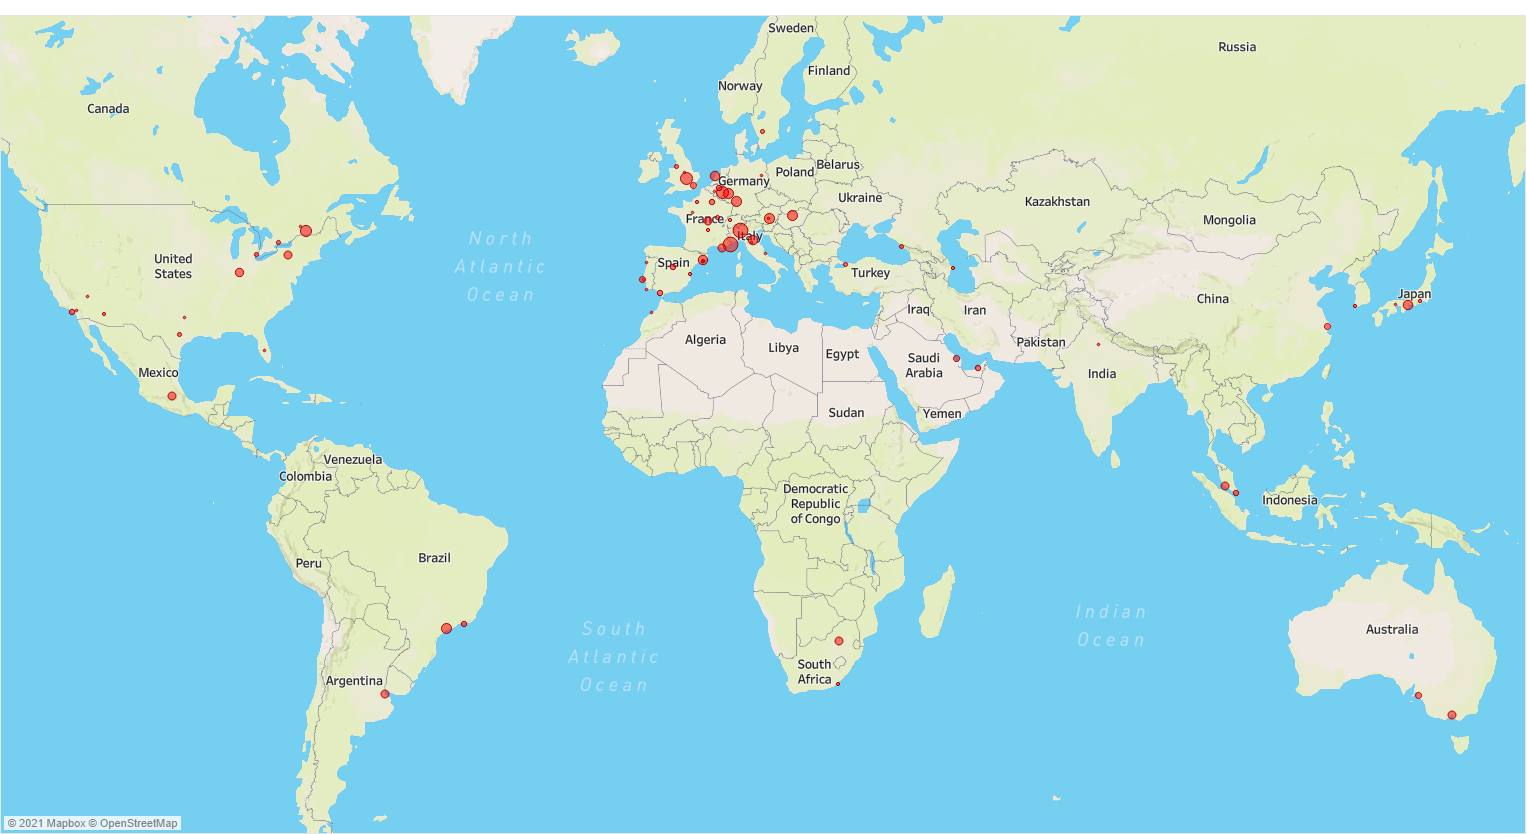

In [90]:
Image(filename='Images/map.png', width=1500)

**Observations**
- As previously seen in the `lat` data distribution, most circuits are located in continent of Europe where F1 originated from, maintaining it's strong roots.
    - This also reveals why most drivers in F1 are European given the abundance of circuit and constructor resources that have been located there.
- As previously seen in the `lng` data distribution, most circuits are located just above the equator where climate is more ideal for outdoor racing circuits.

### Race Rounds
- This bar graph shows the total number of races held each year over time.

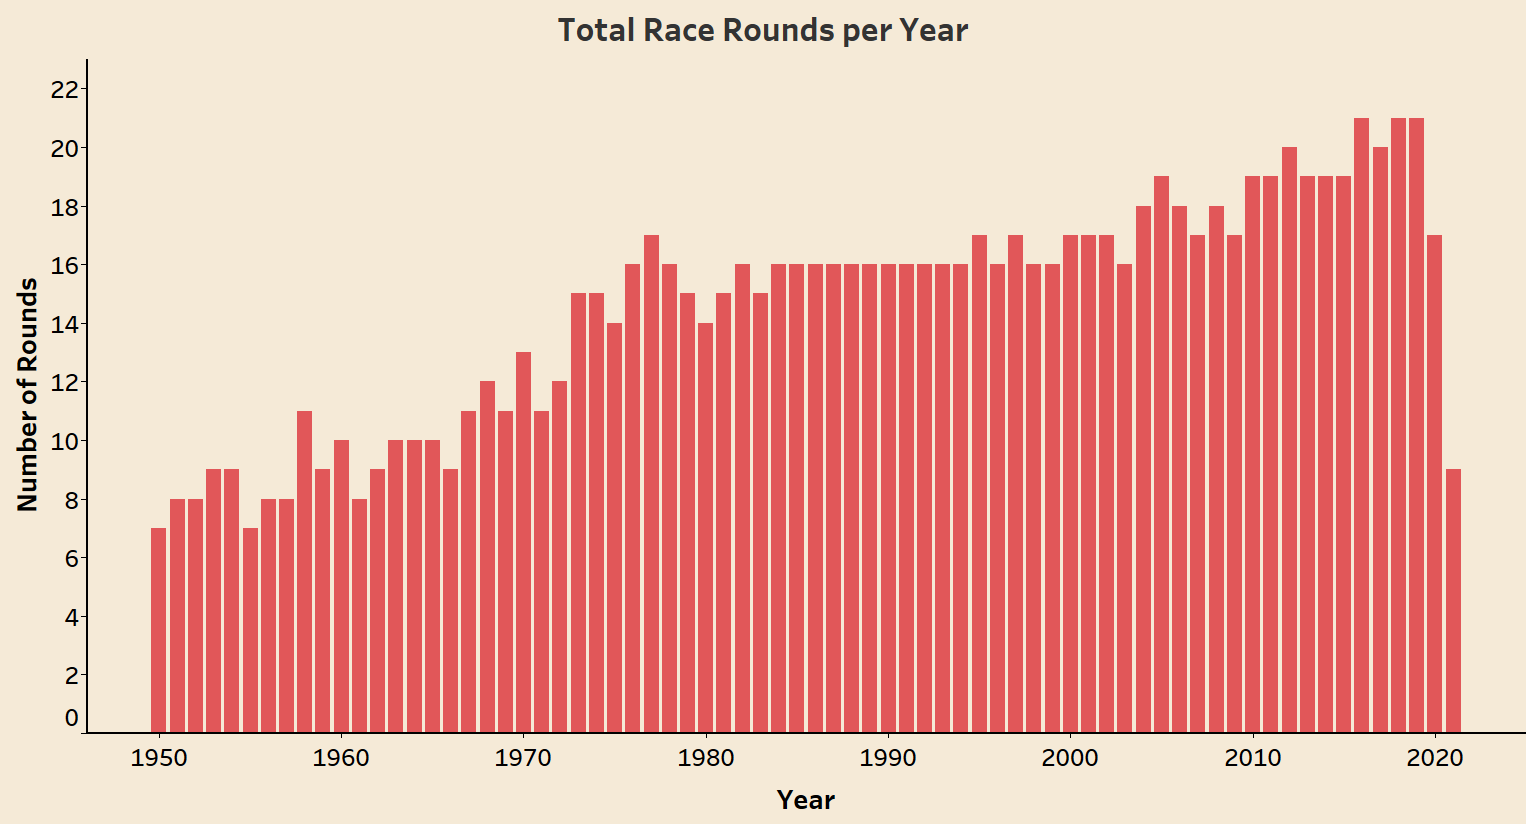

In [91]:
Image(filename='Images/race_rounds.png', width=750) 

**Observations**
- Total number of races each year has slowly increased throughout time which makes sense given more tracks and teams have entered.
- The drop in races for 2020 was due to the covid pandemic.
- As of now, there is only data for the first 9 rounds of the 2021 season.

### Constructors Per Year

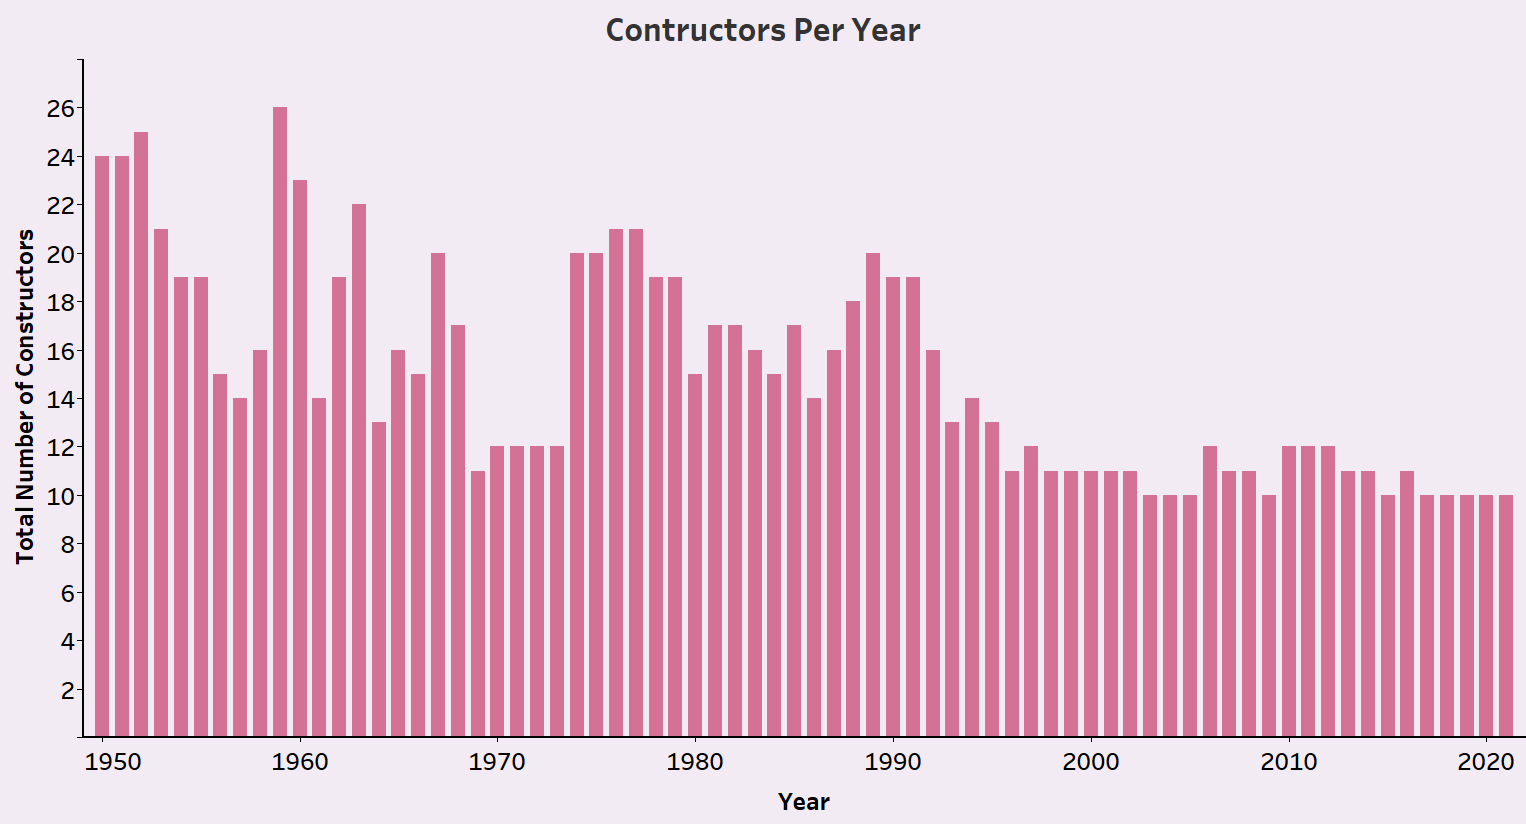

In [92]:
Image(filename='Images/constructors.png', width=750) 

**Observations**
- Total number of constructors each year has slowly decreased throughout time. This could potentially be a result of the overbearing cost F1 demands on both teams and sponsors.
- Given the new cost cap regulations, this trend could reverse in the near future.

### Finishing Position - Target Variable
- This bar graph shoes the top 5, all-time, lowest average race finishing position.

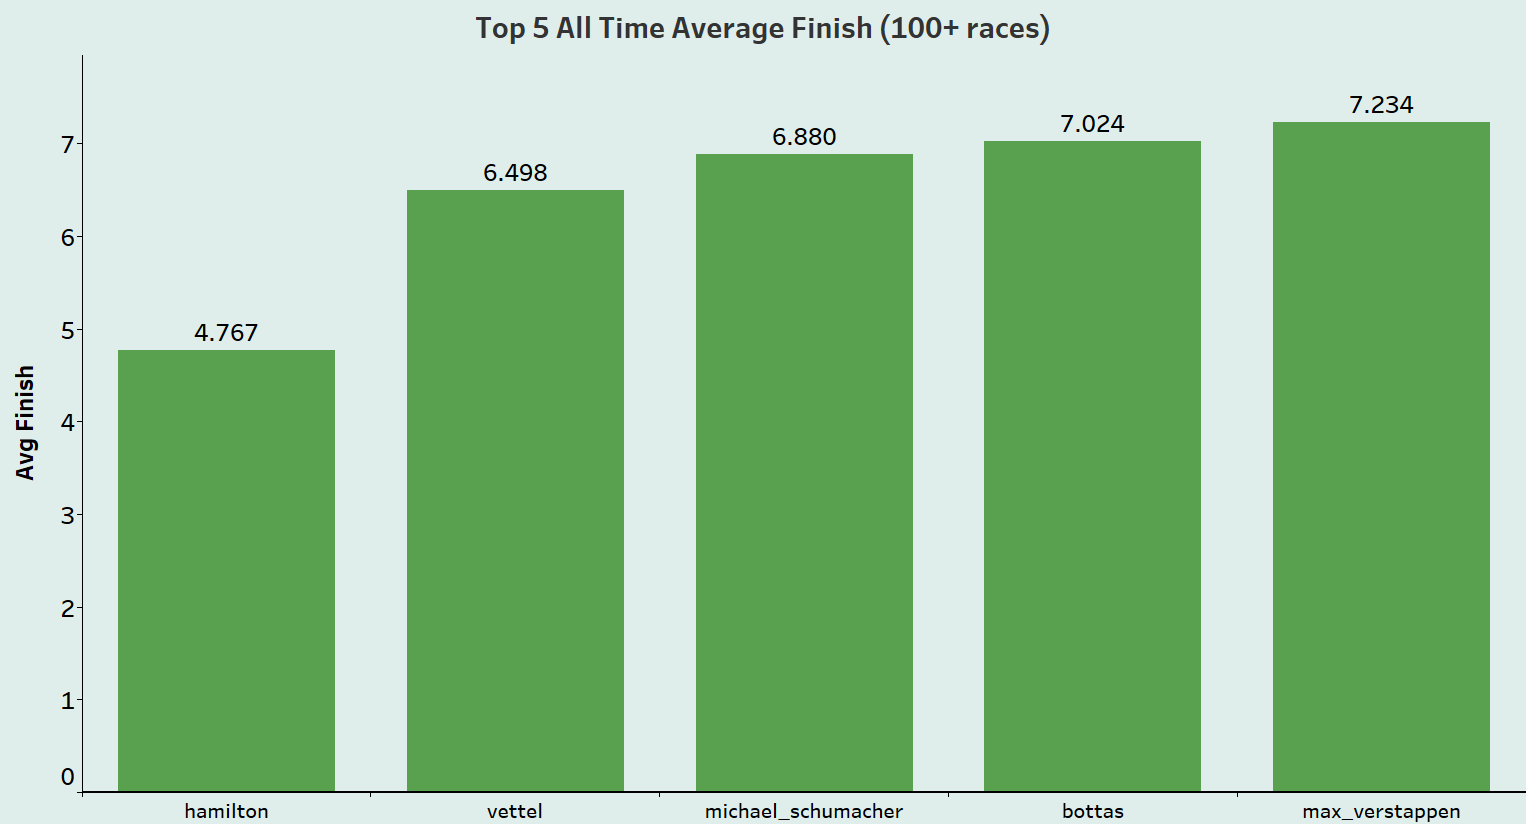

In [93]:
Image(filename='Images/Avg Finish.png', width=750) 

**Observations**
- Top five, all-time lowest average finishes range between ~5th and 7th place.
- Will choose the Top 5 finishing positions as the target variable given this discovery as well as the fact that teams look for overall impressions into new championships when selecting driver as well.

## Next Steps
- Now that the data has been explored, features selected for a final data frame, and distributions visualized, it's time to create some models which takes place in part II found from the **Modeling** notebook. 